# Generative Adversarial Network(GAN)


https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)


In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dens

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
___________________________

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def plot_generated_images(epoch, generator, examples=4, dim=(2,2), figsize=(5,5)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [0]:
import time
import numpy as np
from IPython.display import SVG, display
from PIL import Image

def invert_image(img):
    return( np.invert(img)  )

  
def denomalize_image(img, invert=False):
    if img.dtype is np.dtype(np.float32):
      image = img * 255
      image = image.astype('uint8')
    else:
      image = img
    
    if invert == True:
      image = invert_image( image )

    return( image )
    

def init_display(img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out = display(img_disp, display_id=True)
    else:
      out = display(img_disp.resize((width*zoom,height*zoom)), display_id=True)
    return( out )


def update_display(out, img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out.update(img_disp)
    else:
      out.update(img_disp.resize((width*zoom,height*zoom)))

    

In [0]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    
    display_output = init_display(np.concatenate(X_train[0:batch_size].reshape(batch_size,28,28),axis = 1))

    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 5 == 0:
            #plot_generated_images(e, generator)
            update_display(display_output, np.concatenate( generated_images[0:batch_size].reshape(batch_size,28,28),axis = 1) )


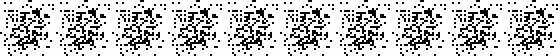

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


 20%|██        | 2/10 [00:00<00:00, 15.15it/s]

Epoch 2


 20%|██        | 2/10 [00:00<00:00, 15.85it/s]

Epoch 3


 20%|██        | 2/10 [00:00<00:00, 14.97it/s]

Epoch 4


 20%|██        | 2/10 [00:00<00:00, 16.26it/s]

Epoch 5


 20%|██        | 2/10 [00:00<00:00, 15.34it/s]

Epoch 6


 20%|██        | 2/10 [00:00<00:00, 16.11it/s]

Epoch 7


 20%|██        | 2/10 [00:00<00:00, 15.69it/s]

Epoch 8


 20%|██        | 2/10 [00:00<00:00, 16.39it/s]

Epoch 9


 20%|██        | 2/10 [00:00<00:00, 15.91it/s]

Epoch 10


 20%|██        | 2/10 [00:00<00:00, 15.63it/s]

Epoch 11


 20%|██        | 2/10 [00:00<00:00, 15.67it/s]

Epoch 12


 20%|██        | 2/10 [00:00<00:00, 16.20it/s]

Epoch 13


 20%|██        | 2/10 [00:00<00:00, 16.38it/s]

Epoch 14


 20%|██        | 2/10 [00:00<00:00, 16.41it/s]

Epoch 15


 20%|██        | 2/10 [00:00<00:00, 15.31it/s]

Epoch 16


 20%|██        | 2/10 [00:00<00:00, 16.44it/s]

Epoch 17


 20%|██        | 2/10 [00:00<00:00, 16.35it/s]

Epoch 18


 20%|██        | 2/10 [00:00<00:00, 15.42it/s]

Epoch 19


 20%|██        | 2/10 [00:00<00:00, 13.71it/s]

Epoch 20


 20%|██        | 2/10 [00:00<00:00, 14.71it/s]

Epoch 21


 20%|██        | 2/10 [00:00<00:00, 16.06it/s]

Epoch 22


 20%|██        | 2/10 [00:00<00:00, 15.87it/s]

Epoch 23


 20%|██        | 2/10 [00:00<00:00, 15.41it/s]

Epoch 24


 20%|██        | 2/10 [00:00<00:00, 15.67it/s]

Epoch 25


 20%|██        | 2/10 [00:00<00:00, 15.62it/s]

Epoch 26


 20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 27


 20%|██        | 2/10 [00:00<00:00, 14.64it/s]

Epoch 28


 20%|██        | 2/10 [00:00<00:00, 16.12it/s]

Epoch 29


 20%|██        | 2/10 [00:00<00:00, 16.30it/s]

Epoch 30


 20%|██        | 2/10 [00:00<00:00, 15.93it/s]

Epoch 31


 20%|██        | 2/10 [00:00<00:00, 16.33it/s]

Epoch 32


 20%|██        | 2/10 [00:00<00:00, 16.15it/s]

Epoch 33


 20%|██        | 2/10 [00:00<00:00, 16.31it/s]

Epoch 34


 20%|██        | 2/10 [00:00<00:00, 15.49it/s]

Epoch 35


 20%|██        | 2/10 [00:00<00:00, 13.23it/s]

Epoch 36


 20%|██        | 2/10 [00:00<00:00, 15.88it/s]

Epoch 37


 20%|██        | 2/10 [00:00<00:00, 15.80it/s]

Epoch 38


 20%|██        | 2/10 [00:00<00:00, 15.98it/s]

Epoch 39


 20%|██        | 2/10 [00:00<00:00, 15.97it/s]

Epoch 40


 20%|██        | 2/10 [00:00<00:00, 16.35it/s]

Epoch 41


 20%|██        | 2/10 [00:00<00:00, 16.43it/s]

Epoch 42


 20%|██        | 2/10 [00:00<00:00, 15.95it/s]

Epoch 43


 20%|██        | 2/10 [00:00<00:00, 15.50it/s]

Epoch 44


 20%|██        | 2/10 [00:00<00:00, 16.52it/s]

Epoch 45


 20%|██        | 2/10 [00:00<00:00, 16.85it/s]

Epoch 46


 20%|██        | 2/10 [00:00<00:00, 16.29it/s]

Epoch 47


 20%|██        | 2/10 [00:00<00:00, 15.99it/s]

Epoch 48


 20%|██        | 2/10 [00:00<00:00, 16.02it/s]

Epoch 49


 20%|██        | 2/10 [00:00<00:00, 16.49it/s]

Epoch 50


100%|██████████| 10/10 [00:00<00:00, 16.69it/s]


In [31]:
training(50,10)